## Cowc dataset, data preprocessing and training on Google CLoud
In this notebook we are going to download the counting data from the [COWC](https://gdo152.llnl.gov/cowc/) dataset. This dataset is used to train a CNN for counting the number of cars in an image. training data images are 256*256 pixels and contains 0-64 cars.
The original dataset is quite messy, and I was not able to find proper informations about the labeling.

In [1]:
#reload libraries if they change and make proper plots
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate

In [2]:
!nvidia-smi

Fri May 15 15:49:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    27W /  70W |     10MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
#import data
dataset = "Potsdam_ISPRS"
data_path = Path("../storage/data/")/dataset
transformed_data_folder = "all_data_transformed"

In [4]:
data_path.ls()


[PosixPath('../storage/data/Potsdam_ISPRS/test'),
 PosixPath('../storage/data/Potsdam_ISPRS/all_data_transformed'),
 PosixPath('../storage/data/Potsdam_ISPRS/all_data'),
 PosixPath('../storage/data/Potsdam_ISPRS/train'),
 PosixPath('../storage/data/Potsdam_ISPRS/export.pkl'),
 PosixPath('../storage/data/Potsdam_ISPRS/models')]

In [5]:
path_train_img = Path("../storage/data/" +dataset +"/train")
path_train_anno = Path("../storage/labels/COWC_train_list_64_class.txt")

path_test_img = Path("../storage/data/" +dataset +"/test")
path_test_anno = Path("../storage/labels/COWC_test_list_64_class.txt")

In [6]:
fnames_train = get_image_files(path_train_img)
fnames_test = get_image_files(path_test_img)
filenames_train = pd.DataFrame(fnames_train, columns = ["path"])
filenames_train["type"] = False
filenames_test = pd.DataFrame(fnames_test, columns = ["path"])
filenames_test["type"] = True
filenames = filenames_train.append(filenames_test)
filenames.describe()

,path,type
count,12800,12800
unique,12800,2
top,../storage/data/Potsdam_ISPRS/train/02.01045.0...,False
freq,1,10722


In [7]:
filenames.head()["path"][0]

PosixPath('../storage/data/Potsdam_ISPRS/train/00.01382.00707.000.png')

In [8]:
#parse image paths from their name
def parse_path(path):
    #return false_path[23:38]
    p = re.compile('([0-9]+.[0-9]+.[0-9]+.[0-9]+).png')
    m = p.search(str(path))
    return m.group(1)

In [9]:
filenames['img_id'] = filenames.apply (lambda row: parse_path(row["path"]), axis=1)
filenames.head()

,path,type,img_id
0,../storage/data/Potsdam_ISPRS/train/00.01382.0...,False,00.01382.00707.000
1,../storage/data/Potsdam_ISPRS/train/00.01747.0...,False,00.01747.00898.090
2,../storage/data/Potsdam_ISPRS/train/00.02163.0...,False,00.02163.00620.165
3,../storage/data/Potsdam_ISPRS/train/08.01600.0...,False,08.01600.00507.135
4,../storage/data/Potsdam_ISPRS/train/00.00251.0...,False,00.00251.00974.165


In [10]:
annotations_train = pd.read_csv(path_train_anno, header= None, sep = " ", index_col = None, names = ["img_false_path","count"])
annotations_train = annotations_train[annotations_train['img_false_path'].str.contains(dataset)]
annotations_train['img_id'] = annotations_train.apply (lambda row: parse_path(row["img_false_path"]), axis=1)

annotations_test = pd.read_csv(path_test_anno, header= None, sep = " ", index_col = None, names = ["img_false_path","count"])
annotations_test = annotations_test[annotations_test['img_false_path'].str.contains(dataset)]
annotations_test['img_id'] = annotations_test.apply (lambda row: parse_path(row["img_false_path"]), axis=1)

annotations = annotations_train.append(annotations_test)
annotations.describe()

,count
count,12800.000000
mean,2.357500
std,2.970413
min,0.000000
25%,0.000000
50%,1.000000
75%,4.000000
max,18.000000


In [11]:
annotations_test.describe()

,count
count,2078.000000
mean,2.119346
std,2.950433
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,16.000000


In [12]:
annotations_train.describe()

,count
count,10722.000000
mean,2.403656
std,2.972199
min,0.000000
25%,0.000000
50%,1.000000
75%,4.000000
max,18.000000


In [13]:
annotations_train.head()

,img_false_path,count,img_id
7595,Potsdam_ISPRS/train/00.00015.00996.030.png,0,00.00015.00996.030
7596,Potsdam_ISPRS/train/00.00015.01306.045.png,0,00.00015.01306.045
7597,Potsdam_ISPRS/train/00.00015.01602.165.png,0,00.00015.01602.165
7598,Potsdam_ISPRS/train/00.00016.01711.165.png,0,00.00016.01711.165
7599,Potsdam_ISPRS/train/00.00023.00703.120.png,0,00.00023.00703.120


In [14]:
annotations = pd.merge(annotations, filenames)
annotations.head()

,img_false_path,count,img_id,path,type
0,Potsdam_ISPRS/train/00.00015.00996.030.png,0,00.00015.00996.030,../storage/data/Potsdam_ISPRS/train/00.00015.0...,False
1,Potsdam_ISPRS/train/00.00015.01306.045.png,0,00.00015.01306.045,../storage/data/Potsdam_ISPRS/train/00.00015.0...,False
2,Potsdam_ISPRS/train/00.00015.01602.165.png,0,00.00015.01602.165,../storage/data/Potsdam_ISPRS/train/00.00015.0...,False
3,Potsdam_ISPRS/train/00.00016.01711.165.png,0,00.00016.01711.165,../storage/data/Potsdam_ISPRS/train/00.00016.0...,False
4,Potsdam_ISPRS/train/00.00023.00703.120.png,0,00.00023.00703.120,../storage/data/Potsdam_ISPRS/train/00.00023.0...,False


In [15]:
annotations.describe()

,count
count,12800.000000
mean,2.357500
std,2.970413
min,0.000000
25%,0.000000
50%,1.000000
75%,4.000000
max,18.000000


In [16]:
annotations[annotations.duplicated(subset="img_id")]

,img_false_path,count,img_id,path,type


In [17]:
#remove duplicates
annotations = annotations.drop_duplicates(subset = "img_id")

In [18]:
np.random.seed(42)
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
bs=256
data = (ImageList.from_df(df = annotations,  path = data_path, folder=transformed_data_folder, cols = ['img_id'], suffix='.png')
        #Where to find the data? -> in planet 'train' folder
        .split_from_df(col="type")
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df(cols = ["count"],label_cls=FloatList)
        #How to label? -> use the second column of the csv file and split the tags by ' '
        .transform(planet_tfms, size=256)
        #Data augmentation? -> use tfms with a size of 128
        .databunch(bs=bs)
        .normalize(imagenet_stats))                          
        #Finally -> use the defaults for conversion to databunch

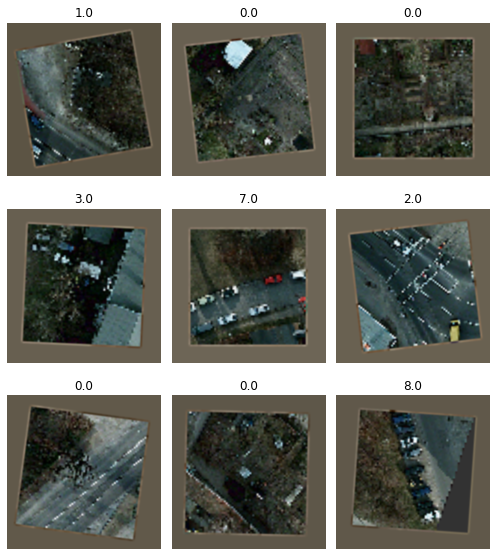

In [19]:
data.show_batch(rows=3, figsize=(7,8))

In [20]:
learn = cnn_learner(data, models.resnet34,loss_func = MSELossFlat(), metrics = mean_squared_error)
#learn.to_fp16() #mixed precision training (faster and less memory intensive)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


AssertionError: 

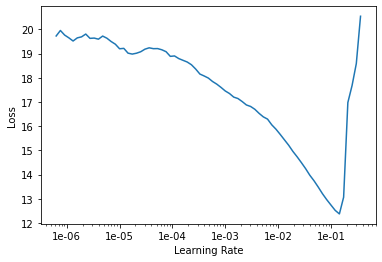

In [21]:
learn.lr_find()
learn.recorder.plot()
assert False

In [22]:

lr = 0.01
learn.fit_one_cycle(4,slice(lr))

epoch,train_loss,valid_loss,mean_squared_error,time
0,9.056454,3.202523,3.202523,00:51
1,4.998648,2.254896,2.254896,00:52
2,3.356963,1.830572,1.830572,00:52
3,2.578294,1.709615,1.709615,00:52


In [ ]:
learn.recorder.plot_losses()

In [ ]:
#train all model again, default trains only last layers
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 0.003
learn.fit_one_cycle(10,slice(lr))

In [ ]:
learn.recorder.plot_losses()

In [24]:
learn.export()

In [26]:
path = learn.path
learn2 = load_learner(path, test=ImageList.from_folder(path_test_img))
preds = learn2.get_preds(ds_type=DatasetType.Test)

In [28]:
doc(learn2.get_preds)

get_preds [source] [test] get_preds ( ds_type : DatasetType = <DatasetType.Valid: 2> , activ : Module = None , with_loss : bool = False , n_batch : Optional [ int ]= None , pbar : Union [ MasterBar , ProgressBar , NoneType ]= None ) → List [ Tensor ] 
 
 × Tests found for get_preds : pytest -sv tests/test_basic_train.py::test_get_preds [source] To run tests please refer to this guide . Return predictions and targets on ds_type dataset. 
 Show in docs

In [ ]:
fastai.utils.show_install()

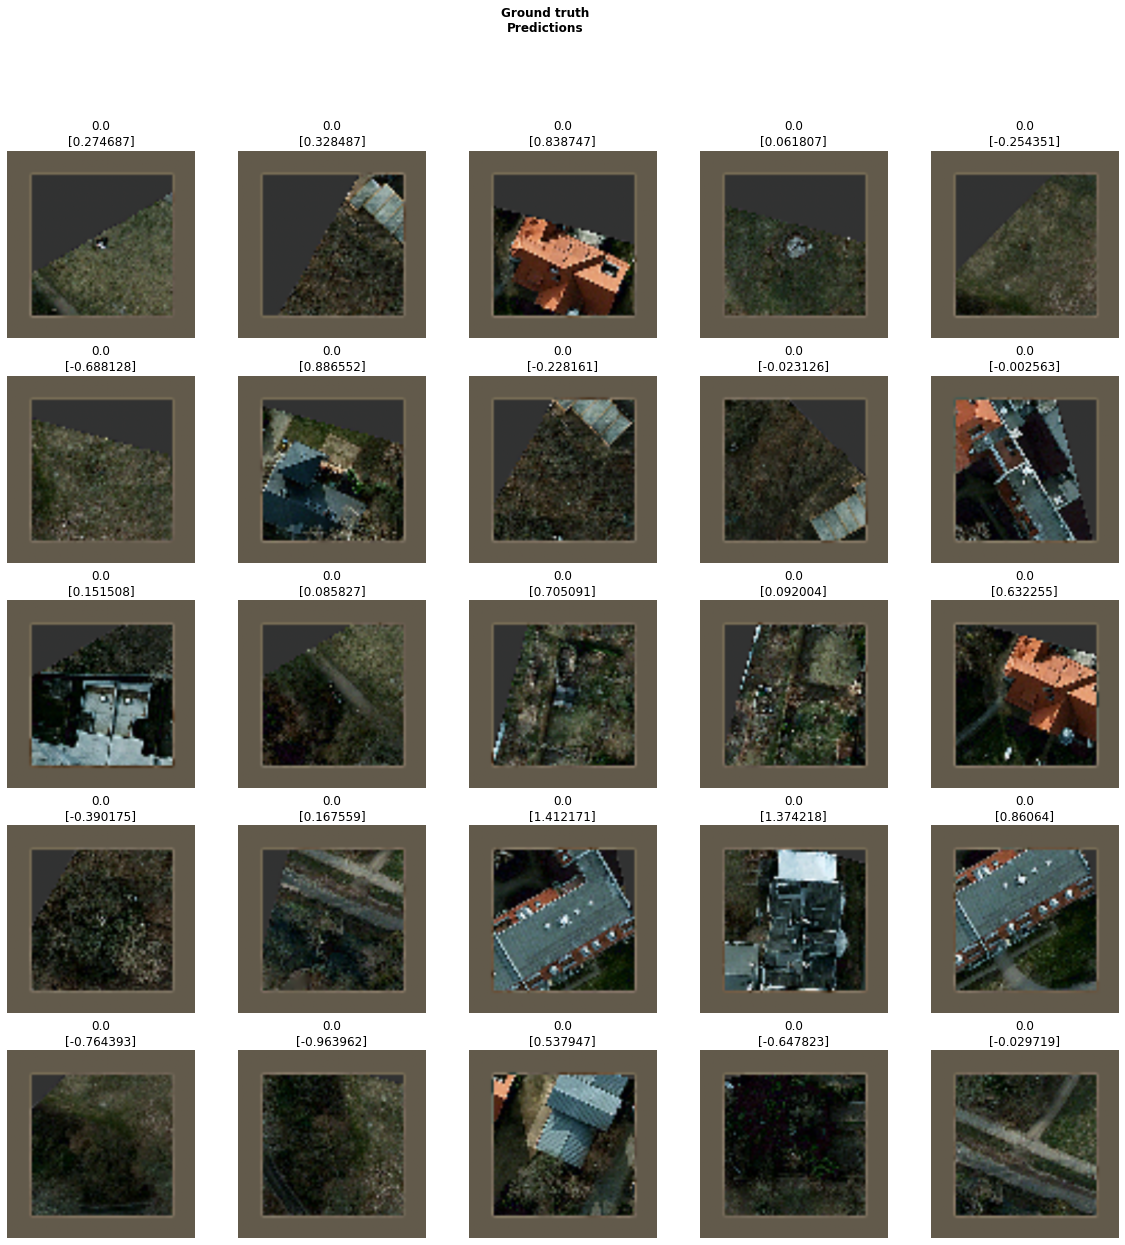

In [33]:
np.random.seed(2)
learn.show_results()